In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-09-27 21:44:32.583882: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 21:44:32.590516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 21:44:32.597931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 21:44:32.600070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 21:44:32.605850: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1727441073.920815    2712 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727441073.992493    2712 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727441073.992521    2712 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import re
import fasttext

# Îç∞Ïù¥ÌÑ∞ Ìò∏Ï∂ú Î∞è ÌååÏïÖ

In [19]:
df = pd.read_csv('./datasets/koco.train.hate.csv', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)
df.columns=['text','label']

In [20]:
df_val = pd.read_csv('./datasets/koco.dev.hate.csv', encoding='utf-8')
# df = df[['text', 'label']]
df_val = df_val.dropna()
df_val = df_val.reset_index(drop=True)
df_val.columns=['text','label']

In [21]:
df['label'].value_counts()

label
none         3486
offensive    2499
hate         1911
Name: count, dtype: int64

In [22]:
df_val['label'].value_counts()

label
offensive    189
none         160
hate         122
Name: count, dtype: int64

In [23]:
df

text label
0     (ÌòÑÏû¨ Ìò∏ÌÖîÏ£ºÏù∏ Ïã¨Ï†ï) ÏïÑ18 ÎÇú ÎßàÎ•∏ÌïòÎäòÏóê ÎÇ†Î≤ºÎùΩÎßûÍ≥† Ìò∏ÌÖîÎßùÌïòÍ≤åÏÉùÍ≤ºÎäîÎç∞ ÎàÑÍµ∞ Í≥ÑÏÜç...  hate
1     ....ÌïúÍµ≠Ï†ÅÏù∏ ÎØ∏Ïù∏Ïùò ÎåÄÌëúÏ†ÅÏù∏ Î∂Ñ...ÎÑàÎ¨¥ÎÇò Í≥±Í≥†ÏïÑÎ¶ÑÎã§Ïö¥Î™®Ïäµ...Í∑∏Î™®ÏäµÎí§Ïùò Ïä¨ÌîîÏùÑ...  none
2     ...Î™ªÎêú ÎÑòÎì§...ÎÇ®Ïùò Í≥†ÌÜµÏùÑ Ï¶êÍ≤ºÎçò ÎÑòÎì§..Ïù¥Ï†† ÎßàÎïÖÌïú Ï≤òÎ≤åÏùÑ Î∞õÏïÑÏïºÏßÄ..,Í∑∏Îûò...  hate
3                    1,2Ìôî Ïñ¥ÏÑ§ÌéêÎäîÎç∞ 3,4Ìôî ÏßÄÎÇòÏÑúÎ∂ÄÌÑ∞Îäî Í∞àÏàòÎ°ù ÎÑàÎ¨¥ Ïû¨Î∞åÎçòÎç∞  none
4     1. ÏÇ¨Îûå ÏñºÍµ¥ ÏÜêÌÜ±ÏúºÎ°ú Í∏ÅÏùÄÍ≤ÉÏùÄ Ïù∏Í≤©ÏÇ¥Ìï¥Ïù¥Í≥†2. ÎèôÏòÅÏÉÅÏù¥ Î™∞Ïπ¥ÎÉê? Î©îÍ±∏Î¶¨ÏïàÎì§ ÏÉùÍ∞Å...  hate
...                                                 ...   ...
7891                                      ÌûòÎÇ¥ÏÑ∏Ïöî~ ÏùëÏõêÌï©ÎãàÎã§!!  none
7892                             ÌûòÎÇ¥ÏÑ∏Ïöî~~ÏÇºÍ∞Ä Í≥†Ïù∏Ïùò Î™ÖÎ≥µÏùÑ ÎπïÎãàÎã§..  none
7893                              ÌûòÎÇ¥ÏÑ∏Ïö© ^^ Ìï≠ÏÉÅ ÏùëÏõêÌï©ÎãàÎã∑ ^^ !  none
7894  ÌûòÎÇ¥ÏÜå...Ïó∞Í∏∞Î°ú ÎãµÌï¥Ïöî.ÎÇòÎèÑ 53ÏÇ¥ Ïù∏Îç∞ Ïù¥Îü∞Ïùº Ï†ÄÎü∞Ïùº Îã§ ÏûàÎçîÎùºÍµ¨Ïöî.Ïù∏Í≤©ÏùÑ ÎØøÏäµ...  none
7895                                 ÌûòÎì§Î©¥ Í¥ÄÎíÄÏñ¥ÏïºÏßÄ Í∑∏Í≤å ÌòÑÎ™ÖÌïúÍ±∞Îã§  none

[7896 rows x 2 columns]

In [24]:
df_val

text      label
0                          ÏÜ°Ï§ëÍ∏∞ ÏãúÎåÄÍ∑πÏùÄ ÎØøÍ≥†Î≥∏Îã§. Ï≤´Ìöå Ïã†ÏÑ†ÌïòÍ≥† Ï¢ãÏïòÎã§.       none
1                                              ÏßÄÌòÑÏö∞ ÎÇòÏÅúÎÜà  offensive
2           ÏïåÎ∞îÏì∞Í≥†ÎßéÏù¥ÎßåÎì§Î©¥ÎêòÏßÄ ÎèàÏöïÏã¨ÏóÜÏúºÎ©¥Í≥®Î™©ÏãùÎãπÏôúÎÇòÏò®Í≤® Í∏∞ÎåïÍ∏∞Í≤åÎÇòÌïòÍ≥† ÏÇ∞ÏóêÍ∞ÄÏÑúÌåîÏñ¥Îùº       hate
3                                     ÏÑ§Îßà „Öà ÌòÑÏ†ï ÏûëÍ∞Ä ÏïÑÎãàÏßÄ??       hate
4    Ïù¥ÎØ∏ÏûêÏî® ÏÜ°ÌòúÍµêÏî® ÎèàÏù¥ Í∑∏Î¶¨ ÎßéÏúºÎ©¥ ÌÉàÏÑ∏ÎßêÍ≥† Í∑∏ÎèàÏúºÎ°ú ÌèâÏÜåÏóê Î∂àÏö∞Ïù¥ÏõÉÏóêÍ≤å Í∏∞Î∂ÄÎèÑ Ï¢Ä...  offensive
..                                                 ...        ...
466                                  ÏßÄÌòÑÏö∞ Î≤îÏ£Ñ Ï†ÄÏßÄÎ•¥ÏßÄ ÏïäÏïòÎÇòÏöî?  offensive
467                                    Ïó¨ÏûêÏù∏ÏÉù ÎßùÏπ† Ïùº ÏûàÎÇò „Öã„Öã       hate
468            Í∑ºÎç∞ Ï†ÑÎùºÎèÑÏóêÏÑú ÏÇ¨Í≥†Í∞Ä ÎÇ¨ÎäîÎç∞ Íµ≥Ïù¥ ÏÑúÏö∏ÍπåÏßÄ ÏôÄÏÑú Î≥ëÏõêÏóê Í∞ÄÎäê Ïù¥Ïú†Îäî?  offensive
469  Ìï†Îß§Ï†ñx, Î±ÉÏÇ¥x, Î™∏Îß§ sÎùºÏù∏, Ïú†Î•úÏùÄ Ï†ÅÎãπÌï¥ÏïºÎê®(ÎÑàÎ¨¥ÌÅ¨Í±∞ÎÇò ÎÑàÎ¨¥ ÏûëÏïÑÎèÑ x), ...       hate
470  ÎÇ®ÏûêÍ∞Ä ÏûòÎ™ªÌïúÍ±∞ÎùºÎ©¥... Î∞òÏÑ±ÎèÑ ÏóÜÎã§Î©¥...ÎÇòÏòÄÎã§Î©¥ ... Ïó¨ÏûêÏ≤òÎüº ÏïÑÏ£º Î™ªÎêòÍ≤å Ìï†...       none

[471 rows x 2 columns]

In [25]:
df['label'] = df['label'].replace({'hate':0, 'offensive':1, 'none':2})
df_val['label'] = df_val['label'].replace({'hate':0, 'offensive':1, 'none':2})

/tmp/ipykernel_2712/164575552.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'hate':0, 'offensive':1, 'none':2})
/tmp/ipykernel_2712/164575552.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_val['label'] = df_val['label'].replace({'hate':0, 'offensive':1, 'none':2})


In [26]:
def replace_space(sentence):
    new = "".join(["" if ch == " " else ch for ch in sentence])
    return new

In [27]:
df

text  label
0     (ÌòÑÏû¨ Ìò∏ÌÖîÏ£ºÏù∏ Ïã¨Ï†ï) ÏïÑ18 ÎÇú ÎßàÎ•∏ÌïòÎäòÏóê ÎÇ†Î≤ºÎùΩÎßûÍ≥† Ìò∏ÌÖîÎßùÌïòÍ≤åÏÉùÍ≤ºÎäîÎç∞ ÎàÑÍµ∞ Í≥ÑÏÜç...      0
1     ....ÌïúÍµ≠Ï†ÅÏù∏ ÎØ∏Ïù∏Ïùò ÎåÄÌëúÏ†ÅÏù∏ Î∂Ñ...ÎÑàÎ¨¥ÎÇò Í≥±Í≥†ÏïÑÎ¶ÑÎã§Ïö¥Î™®Ïäµ...Í∑∏Î™®ÏäµÎí§Ïùò Ïä¨ÌîîÏùÑ...      2
2     ...Î™ªÎêú ÎÑòÎì§...ÎÇ®Ïùò Í≥†ÌÜµÏùÑ Ï¶êÍ≤ºÎçò ÎÑòÎì§..Ïù¥Ï†† ÎßàÎïÖÌïú Ï≤òÎ≤åÏùÑ Î∞õÏïÑÏïºÏßÄ..,Í∑∏Îûò...      0
3                    1,2Ìôî Ïñ¥ÏÑ§ÌéêÎäîÎç∞ 3,4Ìôî ÏßÄÎÇòÏÑúÎ∂ÄÌÑ∞Îäî Í∞àÏàòÎ°ù ÎÑàÎ¨¥ Ïû¨Î∞åÎçòÎç∞      2
4     1. ÏÇ¨Îûå ÏñºÍµ¥ ÏÜêÌÜ±ÏúºÎ°ú Í∏ÅÏùÄÍ≤ÉÏùÄ Ïù∏Í≤©ÏÇ¥Ìï¥Ïù¥Í≥†2. ÎèôÏòÅÏÉÅÏù¥ Î™∞Ïπ¥ÎÉê? Î©îÍ±∏Î¶¨ÏïàÎì§ ÏÉùÍ∞Å...      0
...                                                 ...    ...
7891                                      ÌûòÎÇ¥ÏÑ∏Ïöî~ ÏùëÏõêÌï©ÎãàÎã§!!      2
7892                             ÌûòÎÇ¥ÏÑ∏Ïöî~~ÏÇºÍ∞Ä Í≥†Ïù∏Ïùò Î™ÖÎ≥µÏùÑ ÎπïÎãàÎã§..      2
7893                              ÌûòÎÇ¥ÏÑ∏Ïö© ^^ Ìï≠ÏÉÅ ÏùëÏõêÌï©ÎãàÎã∑ ^^ !      2
7894  ÌûòÎÇ¥ÏÜå...Ïó∞Í∏∞Î°ú ÎãµÌï¥Ïöî.ÎÇòÎèÑ 53ÏÇ¥ Ïù∏Îç∞ Ïù¥Îü∞Ïùº Ï†ÄÎü∞Ïùº Îã§ ÏûàÎçîÎùºÍµ¨Ïöî.Ïù∏Í≤©ÏùÑ ÎØøÏäµ...      2
7895                                 ÌûòÎì§Î©¥ Í¥ÄÎíÄÏñ¥ÏïºÏßÄ Í∑∏Í≤å ÌòÑÎ™ÖÌïúÍ±∞Îã§      2

[7896 rows x 2 columns]

In [28]:
df_val

text  label
0                          ÏÜ°Ï§ëÍ∏∞ ÏãúÎåÄÍ∑πÏùÄ ÎØøÍ≥†Î≥∏Îã§. Ï≤´Ìöå Ïã†ÏÑ†ÌïòÍ≥† Ï¢ãÏïòÎã§.      2
1                                              ÏßÄÌòÑÏö∞ ÎÇòÏÅúÎÜà      1
2           ÏïåÎ∞îÏì∞Í≥†ÎßéÏù¥ÎßåÎì§Î©¥ÎêòÏßÄ ÎèàÏöïÏã¨ÏóÜÏúºÎ©¥Í≥®Î™©ÏãùÎãπÏôúÎÇòÏò®Í≤® Í∏∞ÎåïÍ∏∞Í≤åÎÇòÌïòÍ≥† ÏÇ∞ÏóêÍ∞ÄÏÑúÌåîÏñ¥Îùº      0
3                                     ÏÑ§Îßà „Öà ÌòÑÏ†ï ÏûëÍ∞Ä ÏïÑÎãàÏßÄ??      0
4    Ïù¥ÎØ∏ÏûêÏî® ÏÜ°ÌòúÍµêÏî® ÎèàÏù¥ Í∑∏Î¶¨ ÎßéÏúºÎ©¥ ÌÉàÏÑ∏ÎßêÍ≥† Í∑∏ÎèàÏúºÎ°ú ÌèâÏÜåÏóê Î∂àÏö∞Ïù¥ÏõÉÏóêÍ≤å Í∏∞Î∂ÄÎèÑ Ï¢Ä...      1
..                                                 ...    ...
466                                  ÏßÄÌòÑÏö∞ Î≤îÏ£Ñ Ï†ÄÏßÄÎ•¥ÏßÄ ÏïäÏïòÎÇòÏöî?      1
467                                    Ïó¨ÏûêÏù∏ÏÉù ÎßùÏπ† Ïùº ÏûàÎÇò „Öã„Öã      0
468            Í∑ºÎç∞ Ï†ÑÎùºÎèÑÏóêÏÑú ÏÇ¨Í≥†Í∞Ä ÎÇ¨ÎäîÎç∞ Íµ≥Ïù¥ ÏÑúÏö∏ÍπåÏßÄ ÏôÄÏÑú Î≥ëÏõêÏóê Í∞ÄÎäê Ïù¥Ïú†Îäî?      1
469  Ìï†Îß§Ï†ñx, Î±ÉÏÇ¥x, Î™∏Îß§ sÎùºÏù∏, Ïú†Î•úÏùÄ Ï†ÅÎãπÌï¥ÏïºÎê®(ÎÑàÎ¨¥ÌÅ¨Í±∞ÎÇò ÎÑàÎ¨¥ ÏûëÏïÑÎèÑ x), ...      0
470  ÎÇ®ÏûêÍ∞Ä ÏûòÎ™ªÌïúÍ±∞ÎùºÎ©¥... Î∞òÏÑ±ÎèÑ ÏóÜÎã§Î©¥...ÎÇòÏòÄÎã§Î©¥ ... Ïó¨ÏûêÏ≤òÎüº ÏïÑÏ£º Î™ªÎêòÍ≤å Ìï†...      2

[471 rows x 2 columns]

In [29]:
def is_only_dots(s):
    return all(char == '.' for char in s)

In [30]:
def is_only_space(s):
    return all(char == ' ' for char in s)

In [31]:
def is_only_space_hangul(s):
    return all(ord(char) == 12644 for char in s)

In [32]:
df.shape

(7896, 2)

In [35]:
# dotÎßå Ìè¨Ìï®ÌïòÎäî row
df = df[~df['text'].apply(is_only_dots)]
df_val = df_val[~df_val['text'].apply(is_only_dots)]

In [37]:
print(df.shape)
print(df_val.shape)

(7896, 2)
(471, 2)


In [38]:
df = df[~df['text'].apply(is_only_space)]
df_val = df_val[~df_val['text'].apply(is_only_space)]

In [39]:
print(df.shape)
print(df_val.shape)

(7896, 2)
(471, 2)


In [40]:
df = df[~df['text'].apply(is_only_space_hangul)]
df_val = df_val[~df_val['text'].apply(is_only_space_hangul)]

In [41]:
print(df.shape)
print(df_val.shape)

(7896, 2)
(471, 2)


In [42]:
df = df.reset_index(drop=True)

In [43]:
sam = df[6400:]

In [44]:
sam.shape

(1496, 2)

In [68]:
val_counts = df['label'].value_counts()
print("Train data value count")
print(f"0: {val_counts[0]}Í∞ú {val_counts[0]/len(df)*100:.2f}%")
print(f"1: {val_counts[1]}Í∞ú {val_counts[1]/len(df)*100:.2f}%")
print(f"2: {val_counts[2]}Í∞ú {val_counts[2]/len(df)*100:.2f}%")

Train data value count
0: 1911Í∞ú 24.20%
1: 2499Í∞ú 31.65%
2: 3486Í∞ú 44.15%


In [69]:
val_counts = sam['label'].value_counts()
print("Test data value count")
print(f"0: {val_counts[0]}Í∞ú {val_counts[0]/len(sam)*100:.2f}%")
print(f"1: {val_counts[1]}Í∞ú {val_counts[1]/len(sam)*100:.2f}%")
print(f"2: {val_counts[2]}Í∞ú {val_counts[2]/len(sam)*100:.2f}%")

Test data value count
0: 359Í∞ú 24.00%
1: 468Í∞ú 31.28%
2: 669Í∞ú 44.72%


ÏµúÎåÄ Í∏∏Ïù¥ : 135
ÏµúÏÜå Í∏∏Ïù¥ : 4
Î¶¨Î∑∞Ïùò ÌèâÍ∑† Í∏∏Ïù¥ : 38.710739614994935


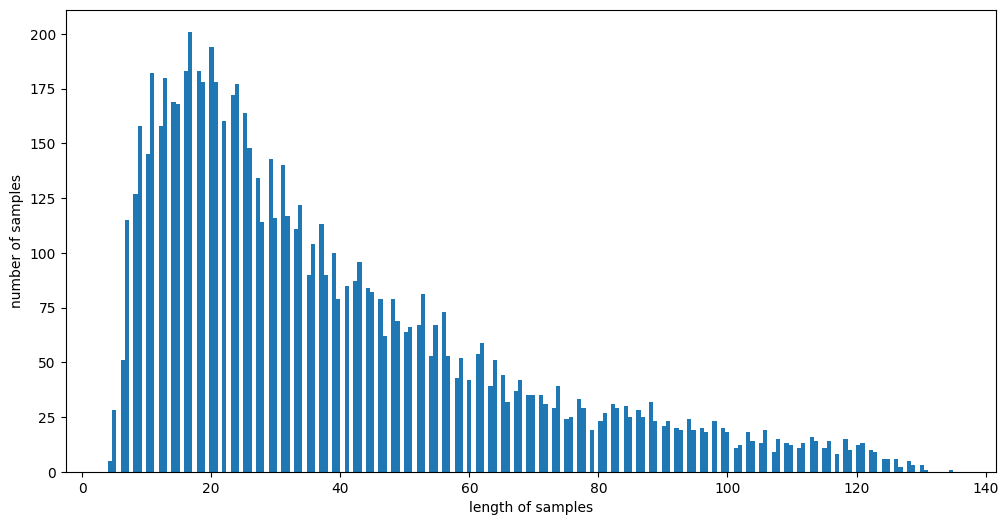

In [70]:
plt.figure(figsize=(12, 6))
print('ÏµúÎåÄ Í∏∏Ïù¥ :', max(len(text) for text in df['text']))
print('ÏµúÏÜå Í∏∏Ïù¥ :', min(len(text) for text in df['text']))
print('Î¶¨Î∑∞Ïùò ÌèâÍ∑† Í∏∏Ïù¥ :', sum(df['text'].str.len())/len(df))
plt.hist([len(text) for text in df['text']], bins=200)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [71]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('Ï†ÑÏ≤¥ ÏÉòÌîå Ï§ë Í∏∏Ïù¥Í∞Ä %s Ïù¥ÌïòÏù∏ ÏÉòÌîåÏùò ÎπÑÏú®: %s'%(max_len, (count / len(nested_list))*100))

In [74]:
threshold = 40

In [75]:
below_threshold_len(threshold, df['text'])

Ï†ÑÏ≤¥ ÏÉòÌîå Ï§ë Í∏∏Ïù¥Í∞Ä 40 Ïù¥ÌïòÏù∏ ÏÉòÌîåÏùò ÎπÑÏú®: 63.28520770010132


In [64]:
counts = df['label'].value_counts()
print(f'Normal speech counts :{counts[0]} ({counts[0]/len(df)*100:.2f}%)')
print(f'Hate speech counts :{counts[1]} ({counts[1]/len(df)*100:.2f}%)')

Normal speech counts :1911 (24.20%)
Hate speech counts :2499 (31.65%)


# Ïù¥ÎØ∏ÏßÄÌôî

In [76]:
# Ïù¥ÎØ∏ÏßÄÎ°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò
def create_sentence_image(sentence, font_path, font_size, background_color=(0, 0, 0), text_color=(255, 255, 255)):
  sentence_split = sentence.split('\n')
  width = len(max(sentence_split, key=len)) # Í∏∏Ïù¥Í∞Ä Í∞ÄÏû• Í∏¥ Î¶¨Ïä§Ìä∏Ïùò Í∏∏Ïù¥Î°ú ÎÑàÎπÑ Í≤∞Ï†ï
  height = len(sentence_split) # Í∞úÌñâÏúºÎ°ú ÎÇòÎà†ÏßÑ Î¶¨Ïä§Ìä∏Ïùò Í∏∏Ïù¥Î°ú ÎÜíÏù¥ Í≤∞Ï†ï

  image_width, image_height = (width*16), height*24  # ÌîΩÏÖÄ ÏÇ¨Ïù¥Ï¶à Ï°∞Ï†ï
  image = Image.new('RGB', (image_width, image_height), background_color)
  draw = ImageDraw.Draw(image)

  # Ìè∞Ìä∏ Ìò∏Ï∂ú
  font = ImageFont.truetype(font_path, font_size)

  # Get the text size
  # text_width, text_height = draw.textlength(sentence, font=font)
  _, _, text_width, text_height = draw.textbbox((0, 0), sentence, font=font)

  # Calculate the position to center the text
  x = (image_width - text_width) // 2
  y = (image_height - text_height) // 2

  # Draw the letter on the image
  draw.text((x, y), sentence, font=font, fill=text_color)

  # Convert image to numpy array
  img_array = np.array(image)

  # Find the bounding box of non-background pixels
  non_background = np.where(img_array != background_color)
  top, left = np.min(non_background[0]), np.min(non_background[1])
  bottom, right = np.max(non_background[0]), np.max(non_background[1])

  # Crop the image
  cropped_image = image.crop((left, top, right+1, bottom+1))

  return cropped_image

In [77]:
# Ìè∞Ìä∏ ÏÑ§Ï†ï
font_path = "./utils/arial-unicode.ttf"
font_size = 12

In [78]:
text = "ÏïàÎÖïÌïòÏÑ∏Ïöî???? ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏûÖÎãàÎã§............."
sample = replace_space(text)
img = create_sentence_image(str(sample), font_path, font_size)
display(img)
img = np.array(img)

In [79]:
print(f"Y axis max value: {img.shape[0]}")
print(f"X axis max value: {img.shape[1]}")

Y axis max value: 11
X axis max value: 237


# coordinates Ï∂îÏ∂ú

In [80]:
# convert image into coordinates
def get_coordinates(img):
  img_arr = np.array(img)
  coordinates = []
  for x in range(len(img_arr)):
    for y in range(len(img_arr[x])):
      if max(img_arr[x][y]) != 0:
        coordinates.append([y,x])
  return np.array(coordinates)

In [81]:
def extract_x_y(img_arr, coordinates):
  # x = np.array([point[0] for point in coordinates]) / len(img_arr[0])
  # y = np.array([point[1] for point in coordinates]) / len(img_arr)
  x = np.array([point[0] for point in coordinates])
  y = np.array([point[1] for point in coordinates])
  # y = 1-y
  return x, y

In [82]:
def draw_text(x, y):
  # plotting
  plt.scatter(x, y, color='blue')

  # Set plot title and labels
  plt.title('Coordinates for Sentence')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Display plot
  plt.show()

In [83]:
coordinates = get_coordinates(img)

In [84]:
coordinates.shape

(965, 2)

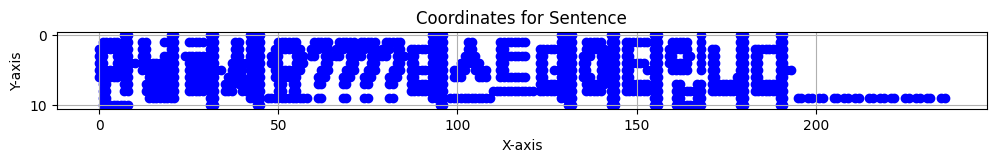

In [85]:
# plotting
import matplotlib.pyplot as plt

x, y = extract_x_y(img, coordinates)

plt.figure(figsize=(12, 1))
plt.scatter(x, y, color='blue')

# Set plot title and labels
plt.title('Coordinates for Sentence')
plt.gca().invert_yaxis()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)  # Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä

# Display plot
plt.show()

# Ï¢åÌëúÍ∞í Ï†ïÍ∑úÌôî

In [86]:
def std_coordinates(data, max_x, max_y):
    standardized_data = np.zeros_like(data, dtype=float)
    standardized_data[:, 0] = data[:, 0] / max_x
    standardized_data[:, 1] = data[:, 1] / max_y
    return standardized_data

In [87]:
coordinates[300]

array([130,   3])

In [88]:
img.shape

(11, 237, 3)

In [89]:
std_coords = std_coordinates(coordinates, img.shape[1], img.shape[0])

In [90]:
std_coords.shape

(965, 2)

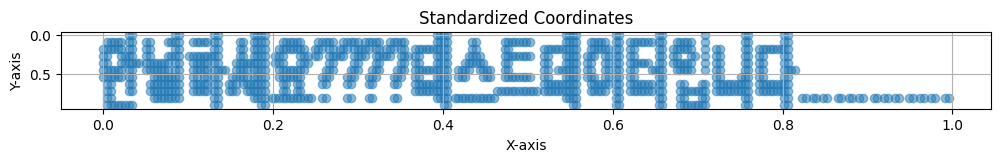

In [91]:
# ÏÇ∞Ï†êÎèÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(12, 1))
plt.scatter(std_coords[:, 0], std_coords[:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # xÏ∂ï Î≤îÏúÑÎ•º 0ÏóêÏÑú 1Î°ú ÏÑ§Ï†ï
# plt.ylim(0, 1)  # yÏ∂ï Î≤îÏúÑÎ•º 0ÏóêÏÑú 1Î°ú ÏÑ§Ï†ï
plt.grid(True)  # Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä

# ÌîåÎ°Ø ÌëúÏãú
plt.show()

In [93]:
padded_coords = pad_coords(std_coords)

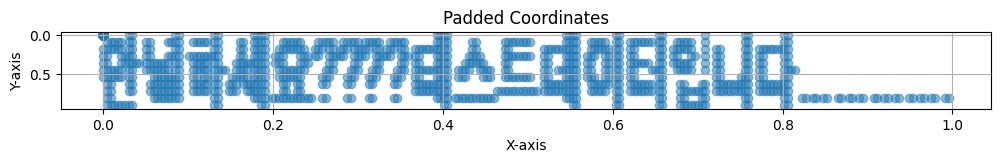

In [94]:
# ÏÇ∞Ï†êÎèÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(12, 1))
plt.scatter(padded_coords[:, 0], padded_coords[:, 1], alpha=0.5)
plt.title('Padded Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)  # xÏ∂ï Î≤îÏúÑÎ•º 0ÏóêÏÑú 1Î°ú ÏÑ§Ï†ï
# plt.ylim(0, 1)  # yÏ∂ï Î≤îÏúÑÎ•º 0ÏóêÏÑú 1Î°ú ÏÑ§Ï†ï
plt.grid(True)  # Í∑∏Î¶¨Îìú Ï∂îÍ∞Ä

# ÌîåÎ°Ø ÌëúÏãú
plt.show()

# Ï†ÑÏ≤òÎ¶¨

In [92]:
# Ìå®Îî©
def pad_coords(coords, pad_size=3000):
    sorted_data = coords[coords[:, 0].argsort()]
    if len(sorted_data) >= pad_size:
        return sorted_data[:pad_size]
    else:
        diff = pad_size - len(sorted_data)
        sorted_data = np.pad(sorted_data, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return sorted_data

In [95]:
# stopwords Ìò∏Ï∂ú
with open('./datasets/stopwords.txt', 'r') as f:
    lines = f.readlines()

# lines = [line.strip() for line in lines]
stopwords = list([line.strip() for line in lines if line != ""][1:])

In [96]:
# fasttext Î™®Îç∏ load
fasttext_model = fasttext.load_model("fasttext_koco_jamo_model.bin")

In [97]:
from jamo import h2j, j2hcj
from konlpy.tag import Okt
okt = Okt()

In [98]:
def vectorize_text(morph_list, model):
    vectors = []
    for i in range(len(morph_list)):
        vectors.append(model[morph_list[i]])
    return vectors

In [99]:
# Ï†ïÍ∑úÏãù Ìå®ÌÑ¥: Í∞ôÏùÄ Î¨∏ÏûêÍ∞Ä 3Î≤à Ïù¥ÏÉÅ Î∞òÎ≥µÎêòÎäî Í≤ΩÏö∞
def reduce_repeated_chars(s):
    pattern = r'(.)\1{2,}'
    return re.sub(pattern, r'\1\1\1', s)

In [100]:
def get_jamo(s):
    reduced_char = reduce_repeated_chars(s)
    words = okt.morphs(reduced_char, norm=True)
    processed_words = [word for word in words if word not in stopwords]
    jamo_list = [j2hcj(h2j(word)) for word in processed_words]
    return jamo_list

In [101]:
s = 'Ïû¨Î∞åÎã§ „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã „Ñ±\-„Öà\- test..... !+ ÌÖåÏä§Ìä∏Îãπ ÏïÑ'
s = reduce_repeated_chars(s)
s = okt.morphs(s, norm=True)
s

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_2712/3797488092.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = 'Ïû¨Î∞åÎã§ „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã „Ñ±\-„Öà\- test..... !+ ÌÖåÏä§Ìä∏Îãπ ÏïÑ'


['Ïû¨Î∞åÎã§', '„Öã„Öã„Öã', '„Ñ±', '\\-', '„Öà', '\\-', 'test', '...', '!+', 'ÌÖåÏä§Ìä∏', 'Îãπ', 'ÏïÑ']

In [102]:
s = 'Ïû¨Î∞åÎã§ „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã „Ñ±\-„Öà\- test..... !+ ÌÖåÏä§Ìä∏Îãπ ÏïÑ'
get_jamo(s)

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_2712/3188698262.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = 'Ïû¨Î∞åÎã§ „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã „Ñ±\-„Öà\- test..... !+ ÌÖåÏä§Ìä∏Îãπ ÏïÑ'


['„Öà„Öê„ÖÅ„Ö£„ÖÜ„Ñ∑„Öè',
 '„Öã„Öã„Öã',
 '„Ñ±',
 '\\-',
 '„Öà',
 '\\-',
 'test',
 '...',
 '!+',
 '„Öå„Öî„ÖÖ„Ö°„Öå„Ö°',
 '„Ñ∑„Öè„Öá']

In [103]:
s = 'Ïû¨Î∞åÎã§ „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã „Ñ±\-„Öà\- test..... !+ ÌÖåÏä§Ìä∏Îãπ ÏïÑ'
replace_space(s)

<>:1: SyntaxWarning: invalid escape sequence '\-'
<>:1: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipykernel_2712/2800769426.py:1: SyntaxWarning: invalid escape sequence '\-'
  s = 'Ïû¨Î∞åÎã§ „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã „Ñ±\-„Öà\- test..... !+ ÌÖåÏä§Ìä∏Îãπ ÏïÑ'


'Ïû¨Î∞åÎã§„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Ñ±\\-„Öà\\-test.....!+ÌÖåÏä§Ìä∏ÎãπÏïÑ'

In [104]:
test = vectorize_text(get_jamo('ÏïàÎÖï? „Öé„Öé ÏÇ¨ÎûëÌï¥'), fasttext_model)

In [105]:
get_jamo("ÏÇ¨ÎûëÌï¥")

['„ÖÖ„Öè„Ñπ„Öè„Öá', '„Öé„Öê']

In [106]:
np.array(test[0]).shape

(100,)

In [107]:
test[-1] == fasttext_model['„Öé„Öê']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [108]:
pad_size = 3000

In [109]:
vector_data = []
coords_data = []
# img_data = []
coords_by_length = []
label_list = []

for i in range(len(df)):
    text = df['text'][i]
    processed_text = get_jamo(text)
    vector_list = vectorize_text(processed_text, fasttext_model)
    if len(vector_list) == 0:
        continue
    else:
        vector_data.append(vector_list)
        # spaceless_text = replace_space(text)
        spaceless_text = replace_space(" ".join(processed_text))
        img = create_sentence_image(spaceless_text, font_path, font_size)
        # resized_img = resize_image(img)
        # img_data.append(resized_img)
        img = np.array(img)
        
        # Ï¢åÌëú Ï∂îÏ∂ú
        coordinates = get_coordinates(img)
        
        x_lim = img.shape[1]
        y_lim = img.shape[0]
        
        # Ï¢åÌëú Ï†ïÍ∑úÌôî
        std_coords = std_coordinates(coordinates, x_lim, y_lim)
        coords_by_length.append(std_coords.shape[0])
        padded_coords = pad_coords(std_coords, pad_size)
    
        coords_data.append(padded_coords)
        label_list.append(df['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(coords_data))

0
1000
2000
3000
4000
5000
6000
7000
Preprocess complete
7896


In [110]:
val_vector_data = []
val_coords_data = []
# img_data = []
val_coords_by_length = []
val_label_list = []

for i in range(len(df_val)):
    text = df_val['text'][i]
    processed_text = get_jamo(text)
    vector_list = vectorize_text(processed_text, fasttext_model)
    if len(vector_list) == 0:
        continue
    else:
        val_vector_data.append(vector_list)
        # spaceless_text = replace_space(text)
        spaceless_text = replace_space(" ".join(processed_text))
        img = create_sentence_image(spaceless_text, font_path, font_size)
        # resized_img = resize_image(img)
        # img_data.append(resized_img)
        img = np.array(img)
        
        # Ï¢åÌëú Ï∂îÏ∂ú
        coordinates = get_coordinates(img)
        
        x_lim = img.shape[1]
        y_lim = img.shape[0]
        
        # Ï¢åÌëú Ï†ïÍ∑úÌôî
        std_coords = std_coordinates(coordinates, x_lim, y_lim)
        val_coords_by_length.append(std_coords.shape[0])
        padded_coords = pad_coords(std_coords, pad_size)
    
        val_coords_data.append(padded_coords)
        val_label_list.append(df['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(val_coords_data))

0
Preprocess complete
471


In [78]:
# # load processed data
# padded_vector_data = np.load('./datasets/padded_vector_data_naver.npy')
# coords_data = np.load('./datasets/coords_data_naver.npy')
# label_list = np.load('./datasets/label_list_naver.npy')

In [111]:
df['text'][0]

'(ÌòÑÏû¨ Ìò∏ÌÖîÏ£ºÏù∏ Ïã¨Ï†ï) ÏïÑ18 ÎÇú ÎßàÎ•∏ÌïòÎäòÏóê ÎÇ†Î≤ºÎùΩÎßûÍ≥† Ìò∏ÌÖîÎßùÌïòÍ≤åÏÉùÍ≤ºÎäîÎç∞ ÎàÑÍµ∞ Í≥ÑÏÜç Ï∂îÎ™®Î∞õÎÑ§....'

In [59]:
# display(img_data[0])

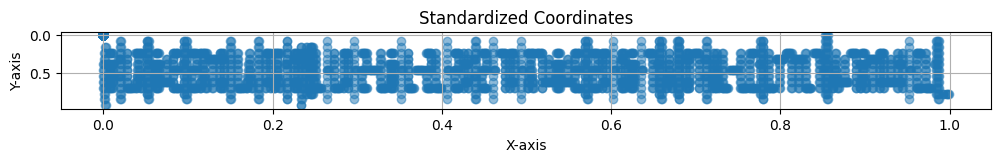

In [114]:
plt.figure(figsize=(12, 1))
plt.scatter(coords_data[0][:, 0], coords_data[0][:, 1], alpha=0.5)
plt.title('Standardized Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().invert_yaxis()
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.grid(True)

# ÌîåÎ°Ø ÌëúÏãú
plt.show()

In [115]:
# coords ÌèâÍ∑† Í∏∏Ïù¥
max_len = max(i for i in coords_by_length)
min_len = min(i for i in coords_by_length)
average = sum(i for i in coords_by_length) / len(coords_by_length)

print("max length: ", max_len)
print("min length: ", min_len)
print("avg length: ", average)

max length:  6458
min length:  28
avg length:  1783.5181104356636


In [116]:
# vector ÌèâÍ∑† Í∏∏Ïù¥
vec_max_len = max(len(i) for i in vector_data)
vec_min_len = min(len(i) for i in vector_data)
vec_average = sum(len(i) for i in vector_data) / len(vector_data)

print("max length: ", vec_max_len)
print("min length: ", vec_min_len)
print("avg length: ", vec_average)

max length:  52
min length:  1
avg length:  13.214918946301925


# Ï†ïÍ∑úÌôî

In [117]:
# vector Ìå®Îî©
def pad_vector(vec, pad_size=30):
    padded = []
    if len(vec) >= pad_size:
        return np.array(vec[:pad_size])
    else:
        diff = pad_size - len(vec)
        padded = np.pad(vec, ((0, diff), (0, 0)), mode='constant', constant_values=0)
    return np.array(padded)

In [118]:
pad_vector(vector_data[0],50).shape

(50, 100)

In [119]:
# Î≤°ÌÑ∞ Ï†úÎ°úÌå®Îî©
padded_vector_data = []
for i in range(len(vector_data)):
    padded_vector_data.append(pad_vector(vector_data[i], 30))
padded_vector_data = np.array(padded_vector_data)

In [120]:
# Î≤°ÌÑ∞ Ï†úÎ°úÌå®Îî©
val_padded_vector_data = []
for i in range(len(val_vector_data)):
    val_padded_vector_data.append(pad_vector(val_vector_data[i], 30))
val_padded_vector_data = np.array(val_padded_vector_data)

In [125]:
print(len(vector_data))
print(len(coords_data))
print(padded_vector_data.shape)

7896
7896
(7896, 30, 100)


In [126]:
print(len(val_vector_data))
print(len(val_coords_data))
print(val_padded_vector_data.shape)

471
471
(471, 30, 100)


# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†

In [129]:
# # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
x_train = padded_vector_data[:6400]
x_train_coords = np.array(coords_data)[:6400]
y_train = np.array(label_list)[:6400]

x_train_val = val_padded_vector_data[:]
x_train_coords_val = np.array(val_coords_data)[:]
y_train_val = np.array(val_label_list)[:]

x_test = padded_vector_data[6400:]
x_test_coords = np.array(coords_data)[6400:]
y_test = np.array(label_list)[6400:]

print(x_train.shape)
print(x_train_coords.shape)
print(y_train.shape)

print(x_train_val.shape)
print(x_train_coords_val.shape)
print(y_train_val.shape)

print(x_test.shape)
print(x_test_coords.shape)
print(y_test.shape)

(6400, 30, 100)
(6400, 3000, 2)
(6400,)
(471, 30, 100)
(471, 3000, 2)
(471,)
(1496, 30, 100)
(1496, 3000, 2)
(1496,)


# Î™®Îç∏ ÏÑ§Í≥Ñ

In [130]:
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, Conv2D, Conv1D, Flatten, Dense, Concatenate, MaxPool2D, MaxPool1D, Dropout, LSTM, Embedding
from tensorflow.keras.models import Model, Sequential

In [144]:
# # Î≤°ÌÑ∞ ÏûÖÎ†•
# vector_input = Input(shape=(30, 100))
# x1 = LSTM(128, activation='relu')(vector_input)
# x1 = Flatten()(x1)

# # Í∏ÄÏûê Ï¢åÌëú ÏûÖÎ†•
# coords_input = Input(shape=(3000,2))
# x2 = Dense(512, activation='relu')(coords_input)
# x2 = Dense(128, activation='relu')(x2)
# x2 = Flatten()(x2)  # Flatten the output of Dense layer

# # Í≤∞Ìï©
# combined = Concatenate()([x1, x2])
# x3 = Dense(64, activation='relu')(combined)
# x3 = Dense(32, activation='relu')(x3)
# output = Dense(1, activation='sigmoid')(x3)

# # Î™®Îç∏ Ï†ïÏùò
# model = Model(inputs=[vector_input, coords_input], outputs=output) --- 84.92 acc


# Î≤°ÌÑ∞ ÏûÖÎ†•
vector_input = Input(shape=(30, 100))
x1 = LSTM(64, activation='relu')(vector_input)
x1 = Flatten()(x1)

# Í∏ÄÏûê Ï¢åÌëú ÏûÖÎ†•
coords_input = Input(shape=(3000,2))
x2 = Dense(512, activation='relu')(coords_input)
x2 = Dense(128, activation='relu')(x2)
x2 = Flatten()(x2)  # Flatten the output of Dense layer

# Í≤∞Ìï©
combined = Concatenate()([x1, x2])
x3 = Dense(64, activation='relu')(combined)
x3 = Dense(32, activation='relu')(x3)
output = Dense(3, activation='softmax')(x3)

# Î™®Îç∏ Ï†ïÏùò
model = Model(inputs=[vector_input, coords_input], outputs=output)

In [29]:
# Ï¢åÌëúÎßå
# Í∏ÄÏûê Ï¢åÌëú ÏûÖÎ†•
coords_input = Input(shape=(3000,2))
x1 = Dense(512, activation='relu')(coords_input)
x1 = Flatten()(x1)  # Flatten the output of Dense layer
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.4)(x1)
output = Dense(1, activation='sigmoid')(x1)

# Î™®Îç∏ Ï†ïÏùò
model = Model(inputs=coords_input, outputs=output)

In [132]:
model = Sequential([
    LSTM(128, input_shape=(30, 100)),
    Dense(1, activation='sigmoid')
])

/home/sdm/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# LSTM, CNN
vector_input = Input(shape=(30, 100))
x1 = LSTM(128, activation='relu')(vector_input)

# Í≤∞Ìï©
coords_input = Input(shape=(3000, 2))
x2 = Conv1D(64, 3, activation='relu')(coords_input)
x2 = MaxPool1D()(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv1D(32, 3, activation='relu')(x2)
x2 = MaxPool1D()(x2)
x2 = Flatten()(x2)

# Í≤∞Ìï©
combined = Concatenate()([x1, x2])
x3 = Dense(512, activation='relu')(combined)
x3 = Dropout(0.25)(x3)
output = Dense(1, activation='sigmoid')(x3)

# Î™®Îç∏ Ï†ïÏùò
model = Model(inputs=[vector_input, coords_input], outputs=output)

In [137]:
model.summary()

Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_3       ‚îÇ (None, 3000, 2)   ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_2       ‚îÇ (None, 30, 100)   ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)     ‚îÇ (None, 3000, 512) ‚îÇ      1,536 ‚îÇ input_layer_3[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)       ‚îÇ (None, 64)        ‚îÇ     42,240 ‚îÇ input_layer_2[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)     ‚îÇ (None, 3000, 128) ‚îÇ     65,664 ‚îÇ dense_5[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_2 (Flatten) ‚îÇ (None, 64)        ‚îÇ          0 ‚îÇ lstm_1[0][0]      ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_3 (Flatten) ‚îÇ (None, 384000)    ‚îÇ          0 ‚îÇ dense_6[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate_1       ‚îÇ (None, 384064)    ‚îÇ          0 ‚îÇ flatten_2[0][0],  ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ flatten_3[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)     ‚îÇ (None, 64)        ‚îÇ 24,580,160 ‚îÇ concatenate_1[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)     ‚îÇ (None, 32)        ‚îÇ      2,080 ‚îÇ dense_7[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)     ‚îÇ 

 Total params: 24,691,779 (94.19 MB)

 Trainable params: 24,691,779 (94.19 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_1 (LSTM)                   ‚îÇ (None, 128)            ‚îÇ       117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                 ‚îÇ (None, 1)              ‚îÇ           129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 117,377 (458.50 KB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.summary()

Model: "functional_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_6 (InputLayer)      ‚îÇ (None, 3000, 2)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                ‚îÇ (None, 3000, 512)      ‚îÇ         1,536 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_6 (Flatten)             ‚îÇ (None, 1536000)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_13 (Dense)                ‚îÇ (None, 128)            ‚îÇ   196,608,128 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_14 (Dense)                ‚îÇ (None, 1)              ‚îÇ           129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 196,609,793 (750.01 MB)

 Trainable params: 196,609,793 (750.01 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# LSTM, CNN
model.summary()

Model: "functional_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_23      ‚îÇ (None, 3000, 2)   ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_17 (Conv1D)  ‚îÇ (None, 2998, 64)  ‚îÇ        448 ‚îÇ input_layer_23[0‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d_15    ‚îÇ (None, 1499, 64)  ‚îÇ          0 ‚îÇ conv1d_17[0][0]   ‚îÇ
‚îÇ (MaxPooling1D)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_5 (Dropout) ‚îÇ (None, 1499, 64)  ‚îÇ          0 ‚îÇ max_pooling1d_15‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_18 (Conv1D)  ‚îÇ (None, 1497, 32)  ‚îÇ      6,176 ‚îÇ dropout_5[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_22      ‚îÇ (None, 30, 100)   ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d_16    ‚îÇ (None, 748, 32)   ‚îÇ          0 ‚îÇ conv1d_18[0][0]   ‚îÇ
‚îÇ (MaxPooling1D)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_11 (LSTM)      ‚îÇ (None, 128)       ‚îÇ    117,248 ‚îÇ input_layer_22[0‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_10          ‚îÇ (None, 23936)     ‚îÇ          0 ‚îÇ max_pooling1d_16‚Ä¶ ‚îÇ
‚îÇ (Flatten)           ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate_9       ‚îÇ (None, 24064)     ‚îÇ          0 ‚îÇ lstm_11[0][0],    ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ flatten_10[0][0]

 Total params: 12,445,665 (47.48 MB)

 Trainable params: 12,445,665 (47.48 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [146]:
batch_size = 32
epochs = 10

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=([x_train_val, x_train_coords_val], y_train_val))

Epoch 1/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 15ms/step - accuracy: 0.4450 - loss: 1.1092 - val_accuracy: 0.3609 - val_loss: 1.9715
Epoch 2/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 10ms/step - accuracy: 0.5748 - loss: 0.9029 - val_accuracy: 0.3737 - val_loss: 2.5321
Epoch 3/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 9ms/step - accuracy: 0.6139 - loss: 0.8178 - val_accuracy: 0.3609 - val_loss: 1.4133
Epoch 4/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 10ms/step - accuracy: 0.6281 - loss: 0.7826 - val_accuracy: 0.3227 - val_loss: 1.6015
Epoch 5/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 10ms/step - accuracy: 0.6783 - loss: 0.7304 - val_accuracy: 0.3652 - val_loss: 1.5949
Epoch 6/10
200/200 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 9ms/step - accuracy: 0.6917 - loss: 0.6982 - val_accuracy: 0.3270 - val_l

In [135]:
# LSTM model
batch_size = 128
epochs = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
1125/1125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 4ms/step - accuracy: 0.8136 - loss: 0.4094 - val_accuracy: 0.8594 - val_loss: 0.3265
Epoch 2/5
1125/1125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 6ms/step - accuracy: 0.8578 - loss: 0.3239 - val_accuracy: 0.8676 - val_loss: 0.3101
Epoch 3/5
1125/1125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 4ms/step - accuracy: 0.8769 - loss: 0.2932 - val_accuracy: 0.8666 - val_loss: 0.3076
Epoch 4/5
1125/1125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 3ms/step - accuracy: 0.8848 - loss: 0.2738 - val_accuracy: 0.8666 - val_loss: 0.3076
Epoch 5/5
1125/1125 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 3ms/step - accuracy: 0.8923 - loss: 0.2549 - val_accuracy: 0.8705 - val_loss: 0.3044


In [32]:
# coords model
batch_size = 128
epochs = 5

# Train the model
history = model.fit(x_train_coords, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 32s 24ms/step - accuracy: 0.5004 - loss: 0.9598 - val_accuracy: 0.5026 - val_loss: 0.6920
Epoch 2/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 21ms/step - accuracy: 0.5054 - loss: 0.6920 - val_accuracy: 0.5016 - val_loss: 0.6923
Epoch 3/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 19ms/step - accuracy: 0.5088 - loss: 0.6908 - val_accuracy: 0.5032 - val_loss: 0.6925
Epoch 4/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 25s 21ms/step - accuracy: 0.5070 - loss: 0.6900 - val_accuracy: 0.5122 - val_loss: 0.6884
Epoch 5/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 25s 21ms/step - accuracy: 0.5096 - loss: 0.6889 - val_accuracy: 0.5145 - val_loss: 0.6856


In [33]:
# LSTM, CNN
batch_size = 128
epochs = 5

# Train the model
history = model.fit([x_train, x_train_coords], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5


2024-09-01 20:44:09.512249: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2527', 8 bytes spill stores, 8 bytes spill loads

2024-09-01 20:44:09.605114: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2527', 4 bytes spill stores, 4 bytes spill loads



1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 15ms/step - accuracy: 0.7479 - loss: 0.5012 - val_accuracy: 0.8491 - val_loss: 0.3420
Epoch 2/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 11ms/step - accuracy: 0.8509 - loss: 0.3442 - val_accuracy: 0.8401 - val_loss: 0.3520
Epoch 3/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 11ms/step - accuracy: 0.8648 - loss: 0.3145 - val_accuracy: 0.8647 - val_loss: 0.3156
Epoch 4/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 13ms/step - accuracy: 0.8735 - loss: 0.2956 - val_accuracy: 0.8673 - val_loss: 0.3222
Epoch 5/5
1196/1196 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 11ms/step - accuracy: 0.8828 - loss: 0.2763 - val_accuracy: 0.8650 - val_loss: 0.3131


# Ï†ïÌôïÎèÑ Í∑∏ÎûòÌîÑ

In [147]:
# Evaluate the model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2024-09-27 22:21:28.771620: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2024-09-27 22:21:28.887355: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 584 bytes spill stores, 396 bytes spill loads



Test loss: 1.0852476358413696
Test accuracy: 0.6009358167648315


In [136]:
# Evaluate LSTM
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.31207460165023804
Test accuracy: 0.8661413192749023


In [33]:
# Evaluate Coords Model
score = model.evaluate(x_test_coords, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6856207847595215
Test accuracy: 0.5129706263542175


In [34]:
# Evaluate LSTM, CNN model
score = model.evaluate([x_test, x_test_coords], y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3192761242389679
Test accuracy: 0.863295316696167


In [34]:
y_test.shape

(29721,)

In [161]:
y_test.shape

(1496,)

In [165]:
# Î≤°ÌÑ∞, Ï¢åÌëú
from sklearn.metrics import f1_score

y_pred = model.predict([x_test, x_test_coords])
y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 score:", f1)

47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step
F1 score: 0.6060501912195689


In [137]:
# LSTM
from sklearn.metrics import f1_score

y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

1242/1242 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1ms/step
F1 score: 0.861827915074972


In [34]:
# coords model
from sklearn.metrics import f1_score

y_pred = model.predict(x_test_coords)
y_pred_binary = (y_pred > 0.5).astype(int)
f1 = f1_score(y_test, y_pred_binary)

print("F1 score:", f1)

929/929 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step
F1 score: 0.6572585418985154


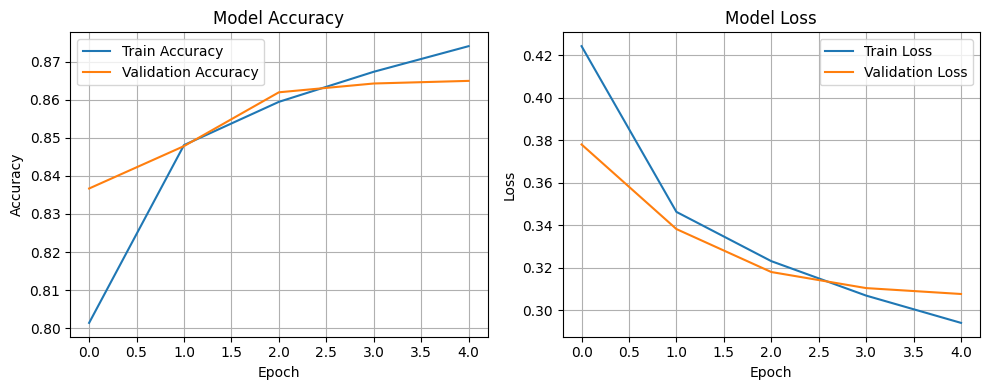

In [146]:
# Î≤°ÌÑ∞, Ï¢åÌëú
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# Ï†ïÌôïÎèÑ Í∑∏ÎûòÌîÑ
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# ÏÜêÏã§ Í∑∏ÎûòÌîÑ
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

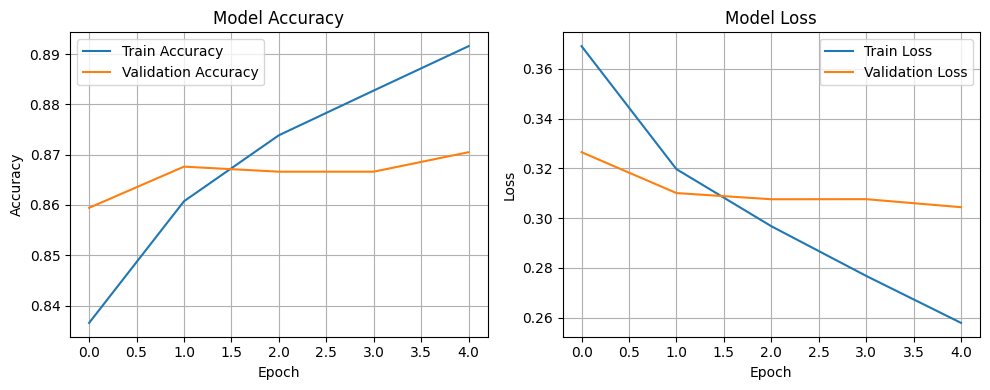

In [138]:
# LSTM
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# Ï†ïÌôïÎèÑ Í∑∏ÎûòÌîÑ
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# ÏÜêÏã§ Í∑∏ÎûòÌîÑ
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

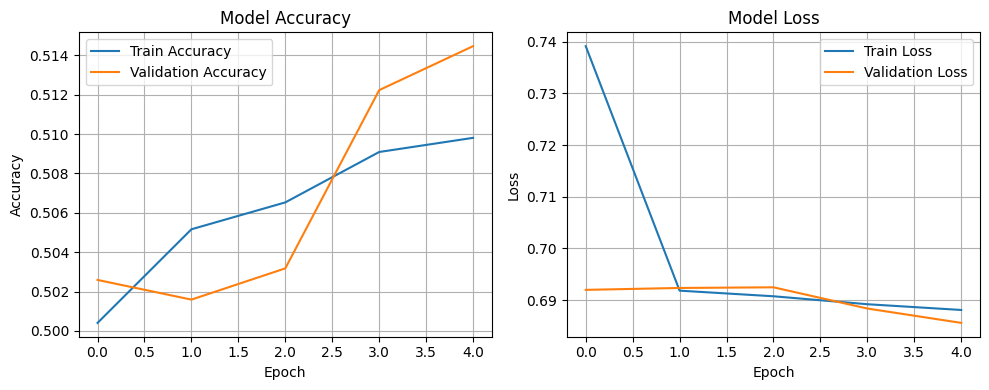

In [35]:
# coords
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1]
# Ï†ïÌôïÎèÑ Í∑∏ÎûòÌîÑ
# plt.subplots(1,2,1)
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# ÏÜêÏã§ Í∑∏ÎûòÌîÑ
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# ÏòàÏ∏° ÏãúÌóò

In [92]:
# model.predict()
def predict_model(text):
    sample_processed_text = get_jamo(text)
    sample_vector = vectorize_text(sample_processed_text, fasttext_model)
    if len(sample_vector) == 0:
        return("String data is too short or not available")
    else:
        sample_spaceless_text = replace_space(" ".join(sample_processed_text))
        sample_img = create_sentence_image(sample_spaceless_text, font_path, font_size)
        sample_img = np.array(sample_img)
        
        # Ï¢åÌëú Ï∂îÏ∂ú
        sample_coordinates = get_coordinates(sample_img)
        
        x_lim = sample_img.shape[1]
        y_lim = sample_img.shape[0]
        
        # Ï¢åÌëú Ï†ïÍ∑úÌôî
        sample_std_coords = std_coordinates(sample_coordinates, x_lim, y_lim)
        sample_padded_coords = pad_coords(sample_std_coords, pad_size)
    
        # ÏòàÏ∏°
        sample_padded_vector = pad_vector(sample_vector, 30)

        sample_padded_vector = sample_padded_vector.reshape(1, 30, 100)
        sample_padded_coords = sample_padded_coords.reshape(1, 3000, 2)
        # print(sample_padded_vector.shape)
        # print(sample_padded_coords.shape)
        predict = model.predict([sample_padded_vector, sample_padded_coords], verbose=0)
        return predict

In [101]:
sample = "ÏÇ¨ÎûëÌï¥"
data = predict_model(sample)

In [102]:
print(data)

[[0.8307285]]


# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞

In [110]:
df = pd.read_csv('./datasets/ratings.txt', sep='\t', encoding='utf-8')
# df = df[['text', 'label']]
df = df.dropna()
df = df.reset_index(drop=True)
df = df[['document', 'label']]
df.columns=['text','label']

In [111]:
# test df
df = df[80000:120000]

In [112]:
df = df.reset_index(drop=True)

In [113]:
df['label'].value_counts()

label
0    20004
1    19996
Name: count, dtype: int64

In [104]:
df

text  label
0                             ÏöîÏ¶òÎÇòÏò§Îäî Ïô†ÎßåÌïú ÏΩîÎØπÏòÅÌôîÎ≥¥Îã§ ÏõÉÍ∏¥ÎìØÌïúÎç∞ „Öã„Öã„Öã      1
1                                         ÌîΩÏÇ¨Ïùò ÎåÄÌëúÏûëÏ§ë ÌïòÎÇòÏßÄ „Öã      1
2                  CGÎèÑ ÎÑàÎ¨¥Ï¢ãÏïòÍ≥† ÎìúÎùºÎßàÏùò Îü¨Î∏åÎùºÏù∏ÎèÑ ÎÑàÎ¨¥Ï¢ãÏïòÎÑ§Ïöî~...Ï≥á.....      1
3                                                      Íµ≥      1
4                                                Ïó≠ÏãúÎäî Ïó≠ÏãúÏó¨      1
...                                                  ...    ...
29964                                    ÎÇòÎäî ÎèÑÎåÄÏ≤¥ Ïù¥Í±∏ Ïôú Î≥∏Í±∏Íπå      0
29965                       Ï¥àÏ†àÏ†ï Ïï°ÏÖò ÌôúÍ∑π... Ïù¥ÎùºÎ©¥ Î≥ÑÏù¥ Ïù¥Î†áÍ≤å ÎßéÍ≤†ÎÉê?      0
29966                                        Î∞òÎã¥Ìòï Ïã§ÎßùÏù¥Ïïº...      0
29967                  Ï∞®Îßà 20Î∂ÑÏùÑ Î≤ÑÌã∞ÏßÄ Î™ªÌïòÍ≥† ÎÇòÏùò ÎààÏùÄ Ï≤òÏ∞∏Ìûà Ïû†Í∏∞Í≥† ÎßêÏïòÎã§      0
29968  ÎÇòÏö∞ÏãúÏπ¥ ÎùºÌì®ÌÉÄ ÏÑºÏπò ÏõêÎ†πÍ≥µÏ£º.. Íµ≥Ïù¥ ÎçîÌïòÏûêÎ©¥ ÌïòÏö∏ÍπåÏßÄ. 5Í∞ú Ïù¥Ïô∏Ïùò ÏßÄÎ∏åÎ¶¨ ÏûëÌíà...      0

[29969 rows x 2 columns]

In [105]:
from utils.char_dict import char_dict
char_dict

{'Íµ¨': 'Â≠ê',
 'Í∑∏': '„É¶',
 'Í≥†': '„É±',
 'ÎÇ¥': 'LH',
 'Îâò': 'Áàø',
 'Îìú': '‚äÜ',
 'ÎåÄ': 'Î®∏',
 'Îçî': '‡™≤',
 'Îîî': '‡™µ',
 'Îü¨': '‡™∏',
 'Î©ç': 'Îåï',
 'Î¨µ': 'Âè∑',
 'Î∞∞': 'ldH',
 'Ïì∞': '‰∏õ',
 'Ïä§': '‰∫º',
 'Ïàò': '„êÉ',
 'Ïä¥': 'Âêà',
 'Ïä•': '‰ªä',
 'Ïï†': 'OH',
 'ÌÅ¨': '„É®',
 'Ìã∞': 'EL',
 'ÌÉú': 'EH',
 'Ï°∞': '‰∏ï',
 'Î•ò': 'ÂºÇ',
 'Îãà': '‰∏©',
 'Ï¢É': 'Â•Ä',
 'Ï¢Ü': 'Â•Ä',
 'Ïóê': '‡™®‡™æ',
 'Ïñ¥': '‡™®',
 'Ï∞∏': '„ÅàÂç†',
 'ÏïÑ': '√ò–ì',
 'Í∫º': '77„Öì',
 'ÏÉà': '‚àßH',
 'ÎÅº': '77l',
 'Í∑Ä': 'Ïª§',
 'Ìë∏': 'Ëæõ',
 'Ï≠à': 'Ï≠à',
 'Ìåú': 'Á´ô',
 '„Öê': 'H',
 '„ÖÇ': 'ld',
 '„Ñπ': 'Â∑±',
 '„ÖÅ': 'Âè£',
 '„ÖÖ': '‰∫∫',
 '„ÖÜ': '‰ªé',
 '„Öá': 'O',
 '„Öä': '„Åà',
 '„Öã': 'ê®õ',
 '„Ñ≤': 'ÂàÄ',
 '„Öå': 'E',
 '„Öó': '„Öó',
 '„Öè': 'Âçú',
 '„Ö†': 'œÄ',
 '„Ñ¥': '„Åó',
 'y': '„Ñö',
 'Y': '„Ñö',
 'N': '–ò',
 'b': '–™',
 'w': 'œâ',
 'X': '„êÖ',
 'H': '„Öê',
 'L': '„Ñ¥',
 'O': '„Öá',
 'T': '„Öú',
 'g': '9',
 '3': '–ó',
 '6': '–ë'}

In [106]:
def change_char(s):
    new_str = ""
    for i in range(len(s)):
        if s[i] in char_dict:
            new_str += char_dict[s[i]]
        else:
            new_str += s[i]
    return new_str

In [125]:
df['text'] = df['text'].apply(lambda text: change_char(text))

In [126]:
df

text  label
0                                            ÎÇú Ïû¨Î∞åÎçòÎç∞?....      1
1                                   Ïª§ÏóΩ„É± Î©ãÏßÄ„É± Ïû¨ÎØ∏ÏûàÎäî. Îß§Î†• Îç©‡™®Î¶¨      1
2                          Ïù¥Î∞©Ïù∏Í≥º ÌòÑÏßÄÏù∏, „É¶Îì§Ïù¥ ÌïòÎÇòÍ∞Ä ÎêòÎäî ÏàúÍ∞ÑÏùò ÏΩîÏù∏Î°úÏª§      1
3                                                      ‚ô•      1
4       Ïõî‚äÜÏªµ Í∏∞Í∞Ñ‡™®‡™æ Î≥¥Í∏∞Ïóî Îî± Ï¢ãÏùÄ ÏòÅÌôî! Ïù¥ ÏòÅÌôîÎßå 100Î≤à ÎÑòÍ≤å Î≥º Ï†ïÎèÑÎ°ú Í∞ïÎ†• Ï∂îÏ≤ú!      1
...                                                  ...    ...
39952  Ï¥àÎ∞òÏùÄ „É¶Îü¥ÎìØÌïòÍ≤å ÎÅå„É± Í∞ÄÏßÄÎßå ÎßàÏßÄÎßâ Í∏âÎßàÎ¨¥Î¶¨Î°ú ÏóâÏÑ±Ìïò„É± ‰∏ïÏïÖÌïú Ïó∞Ï∂úÎ†•Ïù¥ Ïó¨Ïã§Ìûà Îì§...      0
39953  Îí§Ï£º√ò–ì‚äÜÎ£®√ò–ì ‚äÜ Ïπ∏ÌÖî~Ïù¥ÎÇ®ÏûêÏùò Ïó∞Í∏∞‡™®‡™æ Í≤ΩÏïÖ,Îú®ÏïÖ,Ïó¨ldHÏö∞Îì§Ïù¥ ÏôÑÏ†Ñ Ïù¥ÏÅòÎã§~Ìäπ...      0
39954                                  ÎªîÌïú ‰∫ºÌÜ†Î¶¨ ÎªîÌïú Í≤∞Îßê ÏßÑÎ∂ÄÌïòÎã§      0
39955                            ÏïàÎ¨¥ÏÑúÏö¥Ïù¥Ïú†~~Îã§ ÏõêÏûëÏù¥ Ïù¥ÏÉÅÌïú ÌÉìÏù¥ÏßÄ..      0
39956            Î≥ÑÏ†ê10Ï£ºÎäî ÏÇ¨ÎûåÏùÄ Ïù¥Ìï¥Ìï†„êÉÍ∞ÄÏóÜÏùå ÎÅù‡™®‡™æÎèÑ ÌóàÎ¨¥Ìïò„É± Î≥ÑÎ°ú„Ö°„Ö° ÏµúÏïÖÏùòÏòÅÌôî      0

[39957 rows x 2 columns]

In [127]:
test_vector_data = []
test_coords_data = []
# img_data = []
test_coords_by_length = []
test_label_list = []

for i in range(len(df)):
    text = df['text'][i]
    test_processed_text = get_jamo(text)
    test_vector_list = vectorize_text(test_processed_text, fasttext_model)
    if len(test_vector_list) == 0:
        continue
    else:
        test_vector_data.append(test_vector_list)
        # spaceless_text = replace_space(text)
        test_spaceless_text = replace_space(" ".join(test_processed_text))
        test_img = create_sentence_image(test_spaceless_text, font_path, font_size)
        # resized_img = resize_image(img)
        # img_data.append(resized_img)
        test_img = np.array(test_img)
        
        # Ï¢åÌëú Ï∂îÏ∂ú
        test_coordinates = get_coordinates(test_img)
        
        x_lim = test_img.shape[1]
        y_lim = test_img.shape[0]
        
        # Ï¢åÌëú Ï†ïÍ∑úÌôî
        test_std_coords = std_coordinates(test_coordinates, x_lim, y_lim)
        test_coords_by_length.append(test_std_coords.shape[0])
        test_padded_coords = pad_coords(test_std_coords, pad_size)
    
        test_coords_data.append(test_padded_coords)
        test_label_list.append(df['label'][i])

    if i % 1000 == 0:
        print(i)
    
print("Preprocess complete")
print(len(test_coords_data))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
Preprocess complete
39946


In [128]:
# Î≤°ÌÑ∞ Ï†úÎ°úÌå®Îî©
test_padded_vector_data = []
for i in range(len(test_vector_data)):
    test_padded_vector_data.append(pad_vector(test_vector_data[i], 30))
test_padded_vector_data = np.array(test_padded_vector_data)

In [129]:
mod_x_test = test_padded_vector_data[:]
mod_x_test_coords = np.array(test_coords_data)[:]
mod_y_test = np.array(test_label_list)[:]

print(mod_x_test.shape)
print(mod_x_test_coords.shape)
# print(x_test_img.shape)
print(mod_y_test.shape)

(39946, 30, 100)
(39946, 3000, 2)
(39946,)


In [189]:
# Evaluate the model
score = model.evaluate([mod_x_test, mod_x_test_coords], mod_y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.35584402084350586
Test accuracy: 0.8382065892219543


In [190]:
# Î≤°ÌÑ∞, Ï¢åÌëú
from sklearn.metrics import f1_score

mod_y_pred = model.predict([mod_x_test, mod_x_test_coords])
mod_y_pred_binary = (mod_y_pred > 0.5).astype(int)
mod_f1 = f1_score(mod_y_test, mod_y_pred_binary)

print("F1 score:", mod_f1)

1249/1249 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 3ms/step
F1 score: 0.8290980246978872


In [139]:
# Evaluate LSTM
mod_score = model.evaluate(mod_x_test, mod_y_test, verbose=0)
print("Test loss:", mod_score[0])
print("Test accuracy:", mod_score[1])

Test loss: 0.3816642463207245
Test accuracy: 0.8323236107826233


In [140]:
# LSTM
from sklearn.metrics import f1_score

mod_y_pred = model.predict(mod_x_test)
mod_y_pred_binary = (mod_y_pred > 0.5).astype(int)
mod_f1 = f1_score(mod_y_test, mod_y_pred_binary)

print("F1 score:", mod_f1)

1249/1249 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 904us/step
F1 score: 0.8166538924778276
